In [28]:
import json
import re

import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
from transformers import AutoTokenizer


def bytes_to_unicode() -> dict[int, str]:
    """
    Returns list of utf-8 byte and a mapping to unicode strings. We specifically avoids mapping to whitespace/control
    characters the bpe code barfs on.

    The reversible bpe codes work on unicode strings. This means you need a large # of unicode characters in your vocab
    if you want to avoid UNKs. When you're at something like a 10B token dataset you end up needing around 5K for
    decent coverage. This is a significant percentage of your normal, say, 32K bpe vocab. To avoid that, we want lookup
    tables between utf-8 bytes and unicode strings.
    """
    bs = (
        list(range(ord("!"), ord("~") + 1))
        + list(range(ord("¡"), ord("¬") + 1))
        + list(range(ord("®"), ord("ÿ") + 1))
    )
    cs = bs[:]
    n = 0
    for b in range(2**8):
        if b not in bs:
            bs.append(b)
            cs.append(2**8 + n)
            n += 1
    cs = [chr(n) for n in cs]
    return dict(zip(bs, cs, strict=False))


def unicode_to_bytes() -> dict[str, bytes]:
    return {v: bytes([k]) for k, v in bytes_to_unicode().items()}


def cvt_readable_vocab(
    tokenizer, save_path: str | None = None
) -> dict[int, str]:
    """Get readable vocab from tokenizer and save it to a json file"""
    reversed_vocab = {v: k for k, v in tokenizer.vocab.items()}
    added_tokens = tokenizer.added_tokens_encoder
    uni2bytes_mapper = unicode_to_bytes()
    uni2bytes = lambda c: b"".join([uni2bytes_mapper[ch] for ch in c])

    readable = {}
    for k, v in tqdm(
        sorted(reversed_vocab.items(), key=lambda x: x[0]),
        desc="Converting to readable vocab",
    ):
        try:
            if v in added_tokens:
                readable[k] = f"ADDED_TOKEN: {v}"
            else:
                readable[k] = uni2bytes(v).decode("utf-8")
        except:
            readable[k] = f"INVALID UTF-8: {uni2bytes(v)}"

    # save readable vocab_r1.json
    if save_path is not None:
        with open(save_path, "w", encoding="utf-8") as f:
            json.dump(readable, f, indent=2, ensure_ascii=False)

    return readable


def parse_vocab(
    vocab: dict[int, str], verbose: bool = False, save_path: str | None = None
) -> dict[str, dict[int, str]]:
    """Parse the readable vocab by language"""
    unicode_regex = {
        "Added token": r"ADDED_TOKEN",
        "Invalid utf-8": r"INVALID UTF-8",
        # Natural language words
        "English": r'^[—–“”‘’\'"-]?[A-Za-z]+$',
        "Chinese": r"^[\u3400-\u4DBF\u4E00-\u9FFF\uF900-\uFAFF"
        r"\U00020000-\U0002EBEF\U00030000-\U0003134F]+$",
        "Japanese": r"^[\u3040-\u309F\u30A0-\u30FF\u4E00-\u9FFF\u3005\u303B\u309D\u30FD]+$",
        "Korean": r"^[\uAC00-\uD7A3]+$",
        "Indian": r"^[\u0900-\u0DFF]+$",
        "Khmer": r"^[\u1780-\u17FF]+$",
        "Georgian": r"^[\u10A0-\u10FF]+$",
        "Burmese": r"^[\u1000-\u109F]+$",
        "Sinhala": r"^[\u0D80-\u0DFF]+$",
        "Russian": r"^[\u0400-\u04FF]+$",
        "Arabic": r"^[\u0600-\u06FF]+$",
        "Hindi": r"^[\u0900-\u097F]+$",
        "French": r"^[\u00C0-\u00FF]+$",
        "Bengali": r"^[\u0980-\u09FF]+$",
        "Greek": r"^[\u0370-\u03FF\u1F00-\u1FFF]+$",
        "Hebrew": r"^[\u0590-\u05FF]+$",
        "Armenian": r"^[\u0530-\u058F]+$",
        "Thai": r"^[\u0E00-\u0E7F]+$",
        "Tamil": r"^[\u0B80-\u0BFF]+$",
        "Polish": r"^[A-Za-zĄĆĘŁŃÓŚŹŻąćęłńóśźż]+$",
        "Czech": r"^[A-Za-zÁČĎÉĚÍŇÓŘŠŤÚŮŽáčďéěíňóřšťúůžý]+$",
        "Tibetan": r"^[\u0F00-\u0FFF]+$",
        "Latin Extensions and IPA": r"^[\u0250-\u02AF\u1EA0-\u1EFF]+$",
        "Latin Extended": r"^[A-Za-z\u00C0-\u024F\u1E00-\u1EFF]+$",
        # --- Punctuation & Symbols ---
        # 'ASCII Punctuation': r'^[!"#$%&\'()*+,\-./:;<=>?@\[\]\\^_`{|}~]+$',
        "Punctuation": r"^[\s\u0021-\u002F\u003A-\u0040\u005B-\u0060\u007B-\u007E"
        r"\u00A1-\u00BF\u2000-\u206F\u2E00-\u2E7F\u3000-\u303F"
        r"\uFF00-\uFFEF\u2190-\u21FF]+$",
        "Numeric": r"^[0-9]+$",
        "Mathematical": r"^[\u2200-\u22FF][\U0001D400-\U0001D7FF]+$",
        "LaTeX Math Symbols": r"^\\[A-Za-z]+$",
        "Emojis/Symbols": r"^[\U0001F300-\U0001FAFF\u2600-\u26FF]+$",
        "Quotation/Brackets": r"^[\u3000-\u303F\uFF08-\uFF09]+$",
        "Geometric": r"^[\u25A0-\u25FF]+$",
        "Box Drawing": r"^[\u2500-\u257F]+$",
        "Ligatures": r"^[\ufb00-\ufb06]+$",
        # --- Code tokens (common code-style subwords) ---
        "Code": r"^(?:[=.#@*&^_/\(\)\[\]\{\}\|\?\%\$<>+-:;,][A-Za-z0-9_]+(?:\n*)?)$",
        # --- Language-specific subword endings ---
        "Portuguese": r"^[A-Za-zãõçéíóúâêîôû]+$",
        "Italian": r"^[A-Za-zàèéìíîòóùú]+$",
        "German": r"^[A-Za-zäöüßÄÖÜ]+$",
        "Scandinavian": r"^[A-Za-zåÅäÄöÖ]+$",
        "Turkish": r"^[A-Za-zıİğĞçÇşŞöÖüÜ]+$",
        "Vietnamese": r"^[A-Za-zàáảãạăắằẳẵặâầấẩẫậèéẻẽẹêềếểễệìíỉĩịòóỏõọôồốổỗộơờớởỡợùúủũụưừứửữựỳýỷỹỵđ]+$",
    }

    patterns = {k: re.compile(v) for k, v in unicode_regex.items()}

    vocab_by_lang = {"Other": {}, "Whitespace": {}}

    for k, v in tqdm(vocab.items(), desc="Parsing vocab by language"):
        stripped_tok = v.strip()
        if stripped_tok == "":
            vocab_by_lang["Whitespace"][k] = v
            continue

        is_matched = False
        for lang, pat in patterns.items():
            if pat.match(stripped_tok):
                is_matched = True
                if lang == "Added token":
                    v = v.strip("ADDED_TOKEN: ")
                elif lang == "Invalid utf-8":
                    v = v.strip("INVALID UTF-8: ")
                vocab_by_lang.setdefault(lang, {})[k] = v
                break
        if not is_matched:
            vocab_by_lang["Other"][k] = v

    if verbose:
        plot_vocab_by_lang(vocab_by_lang)

    # save the vocab by language in one json file
    if save_path is not None:
        with open(save_path, "w", encoding="utf-8") as f:
            json.dump(vocab_by_lang, f, indent=2, ensure_ascii=False)

    return vocab_by_lang


def plot_vocab_by_lang(
    vocab_by_lang: dict[str, dict[int, str]],
    log_scale: bool = True,
    is_sorted: bool = True,
) -> None:
    lang_counts = {lang: len(vocab) for lang, vocab in vocab_by_lang.items()}
    print(
        f"total vocab: {sum(lang_counts.values())}\n"
        f"Other: {lang_counts['Other']}"
    )
    # plot pie chart and bar chart
    fig, ax = plt.subplots(1, 2, figsize=(20, 10))
    if is_sorted:
        lang_counts = {
            k: v
            for k, v in sorted(
                lang_counts.items(), key=lambda x: x[1], reverse=True
            )
        }

    ax[0].pie(
        lang_counts.values(),
        labels=lang_counts.keys(),
        autopct="%1.1f%%",
        startangle=90,
    )
    ax[0].axis("equal")
    ax[0].set_title("Vocab distribution by language")

    ax[1].bar(lang_counts.keys(), lang_counts.values())
    if log_scale:
        ax[1].set_yscale("log")
    ax[1].set_xticklabels(lang_counts.keys(), rotation=45)
    ax[1].set_title("Vocab distribution by language")

    plt.show()


def dedup_by_whitespace(
    vocab_by_lang, lang: str = "English", verbose: bool = True
) -> set[str]:
    """Find duplicate tokens by stripping whitespace"""
    total_tokens = len(vocab_by_lang[lang])
    dedup = set()
    for k, v in vocab_by_lang[lang].items():
        dedup.add(v.strip())
    if verbose:
        print(
            f"Total {lang} tokens: {total_tokens}\n"
            f"Total unique {lang} tokens: {len(dedup)}\n"
            f"Overlap: {total_tokens - len(dedup)}"
        )
    return dedup


def load_layer_from_safetensor(
    safetensors_path: str,
    layer_name: str = "model.embed_tokens.weight",
    token_list: list[int] = None,
) -> torch.Tensor:
    from safetensors.torch import safe_open

    with safe_open(safetensors_path, framework="pt") as f:
        embeddings = f.get_tensor(layer_name)
    if embeddings.dtype == torch.bfloat16:
        embeddings = embeddings.to(torch.float32)
    if token_list is not None:
        embeddings = embeddings[token_list, :]
    return embeddings


def get_topk_related_tokens(
    token_id: int, ebd: torch.Tensor, k: int = 100, exclude: bool = True
) -> tuple[torch.Tensor, torch.Tensor]:
    """
    Get topk related tokens given a token id
    :param token_id: token id
    :param ebd: embedding layer
    :param k: topk
    :param exclude: exclude the token itself
    :return: topk values and indices
    """
    think_tok = ebd[token_id, :]
    cos = torch.nn.CosineSimilarity(dim=1)
    sim = cos(think_tok, ebd)
    k = k + 1 if exclude else k
    topk = torch.topk(sim, k)
    if exclude:
        return topk.values[1:], topk.indices[1:]
    return topk.values, topk.indices


def tsne(ebd: torch.Tensor, pca_dim: int = None, save_path: str = None) -> None:
    from sklearn.manifold import TSNE

    if pca_dim is not None:
        from sklearn.decomposition import PCA

        pca = PCA(n_components=pca_dim)
        ebd = pca.fit_transform(ebd)

    tsne = TSNE(n_components=2, verbose=1, perplexity=40, metric="cosine")
    tsne_results = tsne.fit_transform(ebd)

    if save_path is not None:
        import numpy as np

        # save tsne results as npy file
        np.save(save_path, tsne_results)

    plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=1)
    plt.show()


def load_tsne(file_path: str, verbose: bool = False):
    import numpy as np

    tsne_results = np.load(file_path)
    if verbose:
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], s=1)
        plt.show()
    return tsne_results


def analyze_tokenizer(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    special_tokens = list(tokenizer.added_tokens_decoder.values())
    special_tokens = [v for v in special_tokens if "<|" not in v.content]
    special_tokens = [v.content for v in special_tokens]
    print(
        f"{model_name} tokenizer \n"
        f"Vocab size: {tokenizer.vocab_size}\n"
        f"Added tokens size: {len(special_tokens)}\n"
        f"Special tokens: {special_tokens}\n"
        f"Vocab length: {len(tokenizer.vocab)}\n"
    )

    readable = cvt_readable_vocab(
        tokenizer, save_path=f"{MODEL_NAME.split('/')[-1]}_vocab_readable.json"
    )
    parse_vocab(
        readable,
        verbose=True,
        save_path=f"{MODEL_NAME.split('/')[-1]}_vocab_by_lang.json",
    )

/home/fanghaotian/src/GRec/ckpt/Instruments/Qwen2-VL-2B-Instruct-finetune-seqrec-qwen7B-with-id-1-freeze/checkpoint-10612 tokenizer 
Vocab size: 151643
Added tokens size: 967
Special tokens: ['<a_0>', '<a_100>', '<a_101>', '<a_102>', '<a_104>', '<a_105>', '<a_106>', '<a_107>', '<a_108>', '<a_109>', '<a_10>', '<a_110>', '<a_111>', '<a_112>', '<a_113>', '<a_114>', '<a_115>', '<a_116>', '<a_117>', '<a_118>', '<a_119>', '<a_11>', '<a_121>', '<a_122>', '<a_123>', '<a_124>', '<a_128>', '<a_129>', '<a_12>', '<a_130>', '<a_131>', '<a_132>', '<a_134>', '<a_135>', '<a_137>', '<a_138>', '<a_139>', '<a_13>', '<a_141>', '<a_142>', '<a_143>', '<a_144>', '<a_145>', '<a_146>', '<a_147>', '<a_148>', '<a_14>', '<a_150>', '<a_151>', '<a_152>', '<a_153>', '<a_155>', '<a_156>', '<a_157>', '<a_15>', '<a_160>', '<a_161>', '<a_162>', '<a_166>', '<a_167>', '<a_169>', '<a_16>', '<a_170>', '<a_171>', '<a_172>', '<a_173>', '<a_174>', '<a_175>', '<a_176>', '<a_177>', '<a_178>', '<a_179>', '<a_17>', '<a_180>', '<a_

Parsing vocab by language: 100%|██████████| 152624/152624 [00:00<00:00, 367919.63it/s]
/tmp/ipykernel_1792429/1712808183.py:193: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(lang_counts.keys(), rotation=45)


total vocab: 152624
Other: 2705


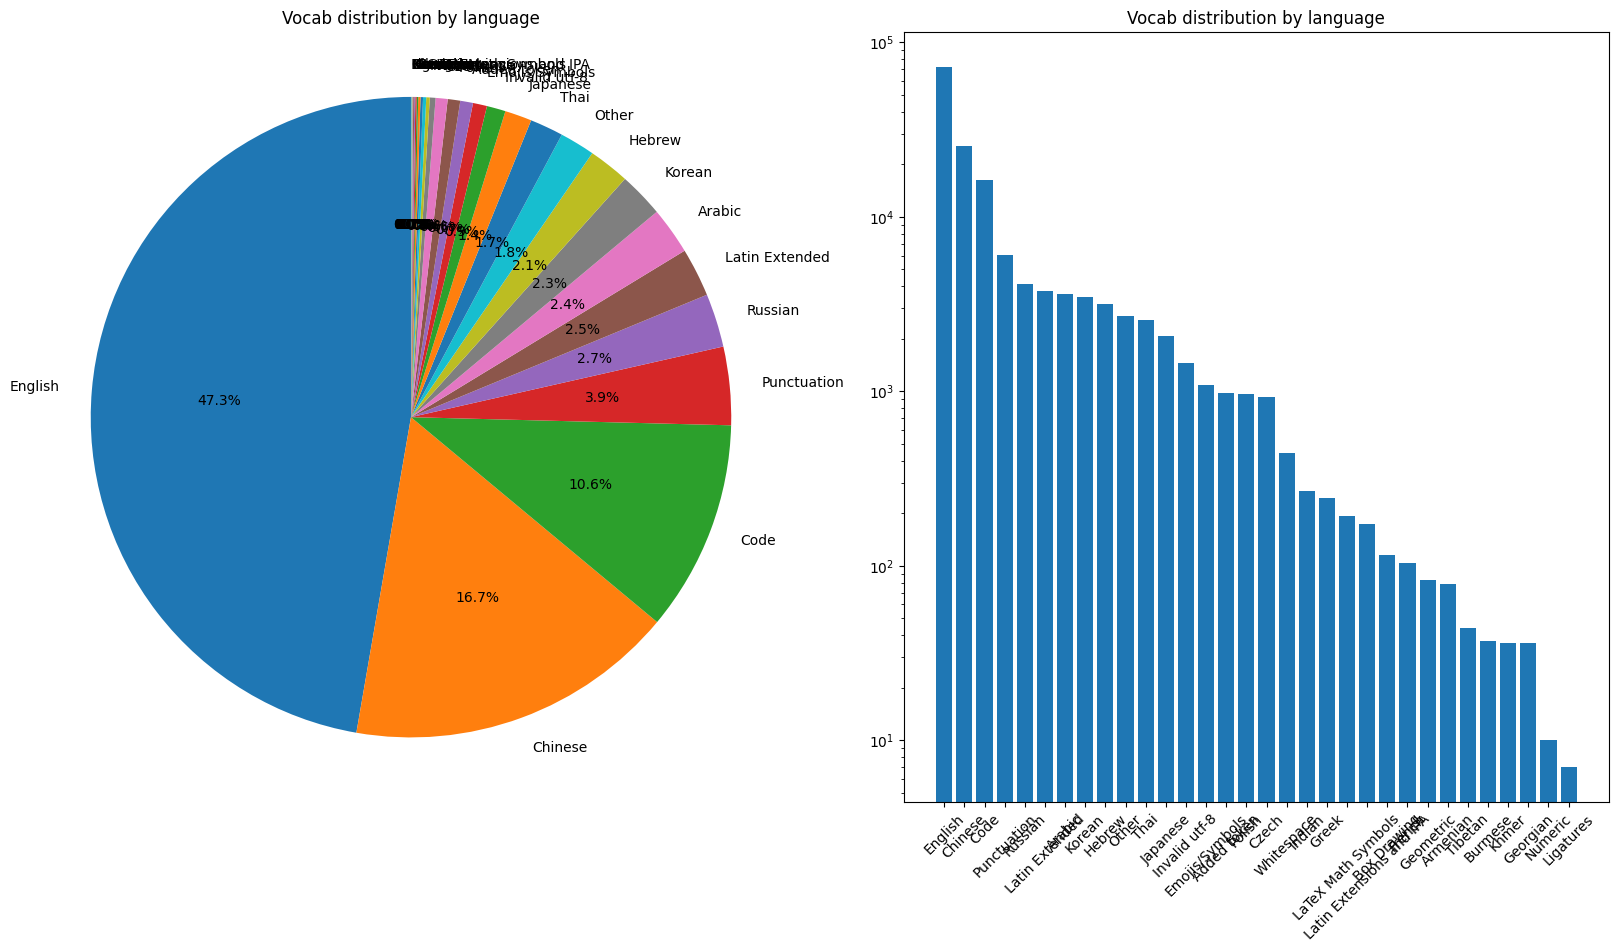

In [29]:
MODEL_1 = "/home/fanghaotian/src/GRec/ckpt/Instruments/Qwen2-VL-2B-Instruct-finetune-seqrec-qwen7B-with-id-1-freeze/checkpoint-10612"
# MODEL_DS_R1 = "deepseek-ai/DeepSeek-R1"
# MODEL_DS_v3 = "deepseek-ai/DeepSeek-v3"
# MODEL_DS_v2 = "deepseek-ai/DeepSeek-v2"
# MODEL_QWEN_2_5 = "Qwen/Qwen2.5-72B"
# MODEL_MISTRAL_SMALL_24B = "mistralai/Mistral-Small-24B-Instruct-2501"
MODEL_NAME = MODEL_1

analyze_tokenizer(MODEL_NAME)

In [34]:
def analyze_tsne(model_name: str):
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    token_list = list(tokenizer.added_tokens_decoder.keys())
    print(token_list)
    safetensor_path = model_name + "/model.safetensors"
    ebd = load_layer_from_safetensor(safetensor_path, token_list=token_list)
    tsne(ebd, save_path=f"{model_name.split('/')[-1]}_tsne.npy")

In [5]:
import torch

torch.cuda.set_device(4)

[151643, 151644, 151645, 151646, 151647, 151648, 151649, 151650, 151651, 151652, 151653, 151654, 151655, 151656, 151657, 151658, 151659, 151660, 151661, 151662, 151663, 151664, 151665, 151666, 151667, 151668, 151669, 151670, 151671, 151672, 151673, 151674, 151675, 151676, 151677, 151678, 151679, 151680, 151681, 151682, 151683, 151684, 151685, 151686, 151687, 151688, 151689, 151690, 151691, 151692, 151693, 151694, 151695, 151696, 151697, 151698, 151699, 151700, 151701, 151702, 151703, 151704, 151705, 151706, 151707, 151708, 151709, 151710, 151711, 151712, 151713, 151714, 151715, 151716, 151717, 151718, 151719, 151720, 151721, 151722, 151723, 151724, 151725, 151726, 151727, 151728, 151729, 151730, 151731, 151732, 151733, 151734, 151735, 151736, 151737, 151738, 151739, 151740, 151741, 151742, 151743, 151744, 151745, 151746, 151747, 151748, 151749, 151750, 151751, 151752, 151753, 151754, 151755, 151756, 151757, 151758, 151759, 151760, 151761, 151762, 151763, 151764, 151765, 151766, 151767,

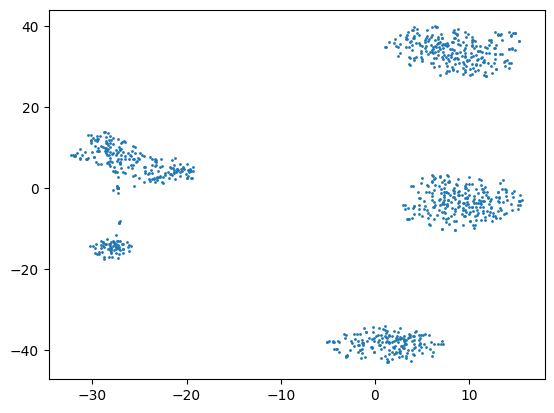

In [35]:
analyze_tsne(MODEL_NAME)